# 1. Import các thư viện cần thiết

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd 
import os 
import cv2

In [5]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.17.1'

In [6]:
DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"
# cấu trúc file
print(os.listdir(DATASET_PATH))

['images.csv', 'images', 'styles.csv', 'styles']


# 2. Chuẩn bị và quan sát dữ liệu

In [7]:
# đọc bảng dữ liệu từ 
# df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines='warn')
df = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines='skip', nrows=50)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [8]:
# các trường thông tin của data
df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
      dtype='object')

array([[<Axes: title={'center': 'year'}>]], dtype=object)

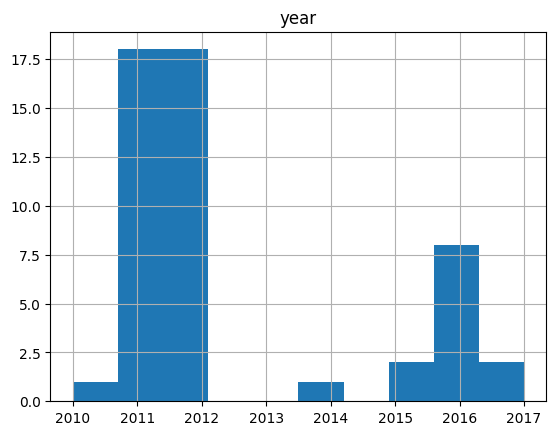

In [9]:
# Quan sát phân phối năm trong fashion data
df.hist("year")

<Axes: ylabel='count'>

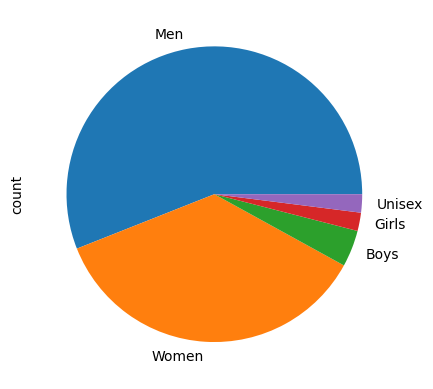

In [10]:
df.gender.value_counts().plot(kind='pie')

<Axes: ylabel='articleType'>

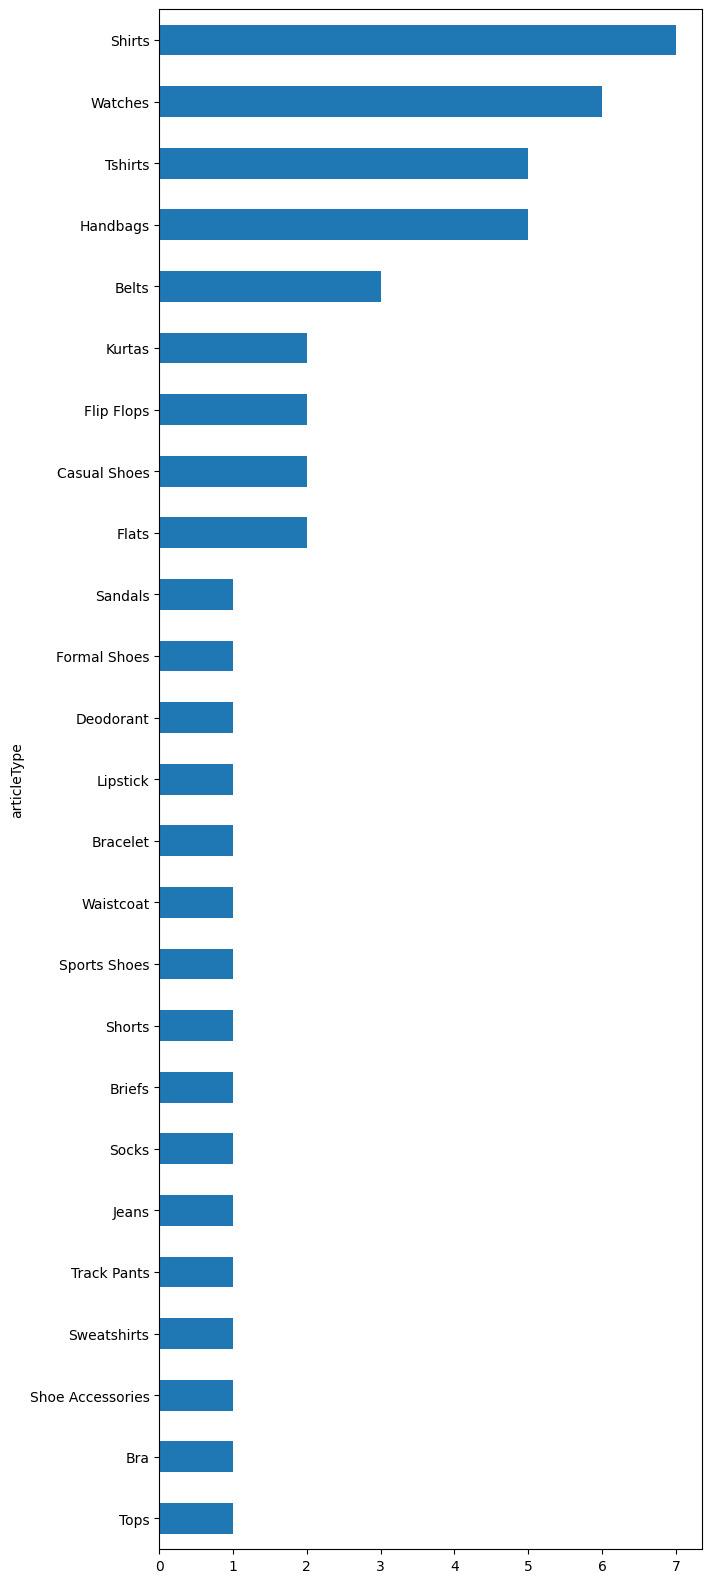

In [11]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [12]:
# hàm vẽ ảnh
def plot_figures(figures, nrows = 1, ncols=1,figsize=(10, 10)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

# lấy path image
def img_path(img):
    return DATASET_PATH+"/images/"+img

# load ảnh từ path
def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

In [13]:
# xóa các ảnh bị lỗi
for i, row in df.iterrows():
    print(f"image {i}: ", row.image)
    try:
        img = cv2.imread(img_path(row.image))
        w, h, _ = img.shape
    except Exception as e:
        print(e)
        df = df.drop(df[df['image'] == row.image].index)
        print('error_image_deleted: ', row.image)
        

image 0:  15970.jpg
image 1:  39386.jpg
image 2:  59263.jpg
image 3:  21379.jpg
image 4:  53759.jpg
image 5:  1855.jpg
image 6:  30805.jpg
image 7:  26960.jpg
image 8:  29114.jpg
image 9:  30039.jpg
image 10:  9204.jpg
image 11:  48123.jpg
image 12:  18653.jpg
image 13:  47957.jpg
image 14:  46885.jpg
image 15:  12369.jpg
image 16:  29928.jpg
image 17:  42419.jpg
image 18:  51832.jpg
image 19:  47359.jpg
image 20:  17429.jpg
image 21:  12967.jpg
image 22:  6842.jpg
image 23:  13089.jpg
image 24:  18461.jpg
image 25:  9036.jpg
image 26:  48311.jpg
image 27:  7990.jpg
image 28:  56019.jpg
image 29:  21977.jpg
image 30:  37812.jpg
image 31:  4729.jpg
image 32:  56825.jpg
image 33:  39988.jpg
image 34:  59051.jpg
image 35:  20099.jpg
image 36:  58183.jpg
image 37:  29742.jpg
image 38:  51658.jpg
image 39:  3954.jpg
image 40:  18839.jpg
image 41:  2886.jpg
image 42:  23278.jpg
image 43:  28690.jpg
image 44:  8580.jpg
image 45:  3168.jpg
image 46:  18005.jpg
image 47:  17871.jpg
image 48:  9

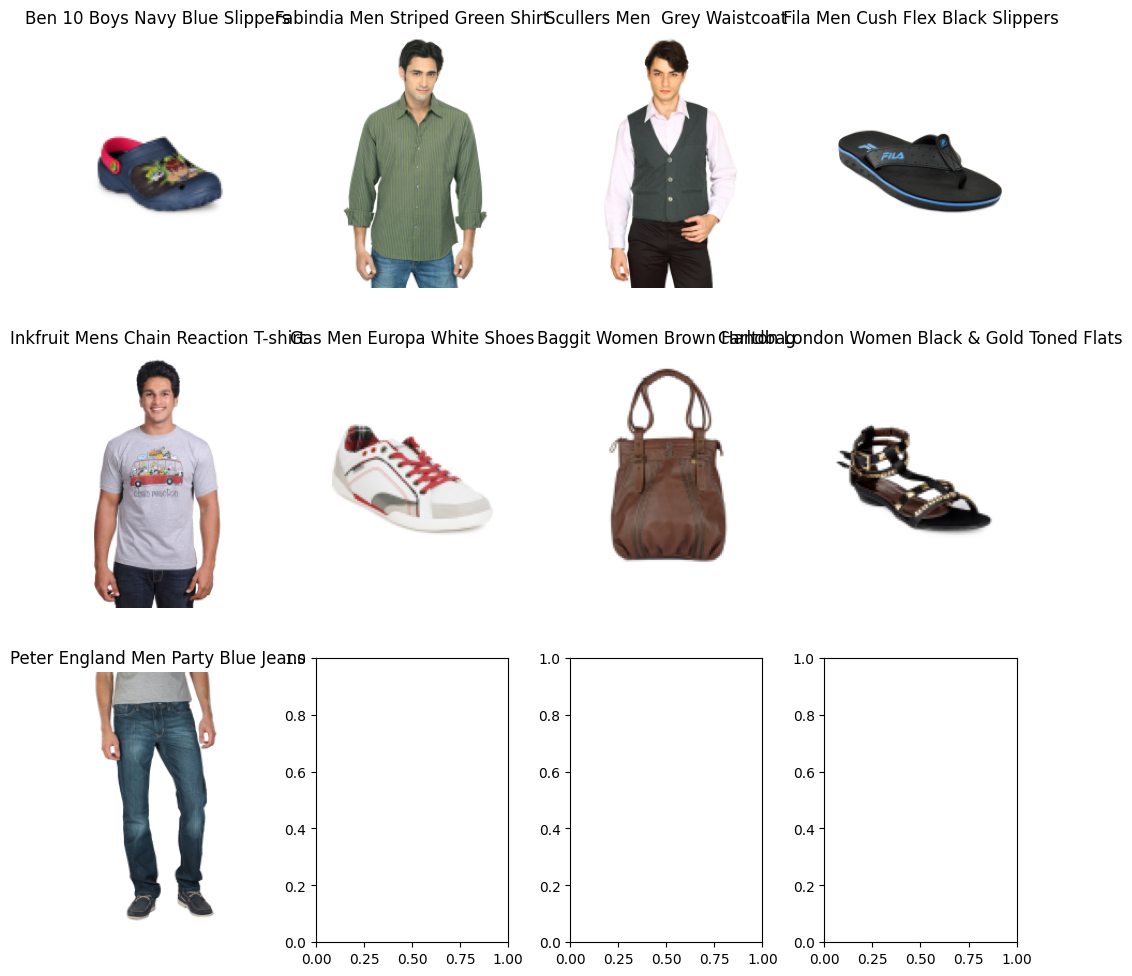

In [18]:
# lấy 6 ảnh bất kì trong data
figures = {str(row.productDisplayName): load_image(row.image) for i, row in df.sample(9).iterrows()}

# vẽ ảnh 3 hàng, 2 cột
plot_figures(figures, 3, 4)

  # 3. Xây dựng mô hình CNN

In [19]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
# hàm embedding
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(240, 180, 3)
[5.79042   9.593653  0.        ... 0.3726998 0.        8.903797 ]
CPU times: user 4.11 s, sys: 317 ms, total: 4.43 s
Wall time: 5.09 s


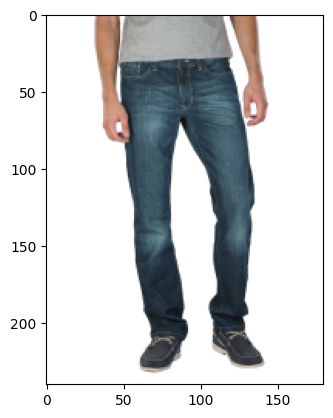

In [21]:
%%time
emb = get_embedding(model, df.iloc[1].image)
img_array = load_image(df.iloc[1].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

# 4. Lưu trữ dữ liệu và tìm kiếm với FAISS

In [22]:
%%time
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.939161,2.372257,0.000000,3.246124,0.957502,2.766368,8.801991,6.304142,0.805902,1.697341,...,2.396975,0.000000,1.801754,20.561764,3.954428,0.000000,8.289474,1.359551,0.000000,10.893190
1,5.790420,9.593653,0.000000,9.431681,0.287235,0.259945,17.028753,3.037462,0.136338,0.000000,...,1.670570,0.013895,10.338688,4.784727,0.189144,0.000000,7.739136,0.372700,0.000000,8.903797
2,0.000000,3.162252,0.484697,0.172294,2.609543,3.840853,3.426137,0.253247,1.098906,1.418276,...,0.434925,14.092848,3.018753,2.134509,2.549053,0.377387,6.180350,0.636622,14.018171,11.415053
3,5.882202,1.958614,0.000000,12.519881,0.000000,0.000000,9.383596,3.781615,0.000000,1.490626,...,17.825481,0.000000,3.592509,2.042307,0.000000,0.000000,6.656784,1.457310,1.694205,1.403323
4,0.245969,17.383432,0.493825,3.374465,2.567373,0.000000,6.482544,5.862634,0.000000,3.164866,...,4.464022,0.447080,1.448137,12.884142,0.000000,0.397494,5.028075,1.939697,0.000000,11.485400


In [24]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.3 MB/s eta 0:00:00:00:0100:01


In [40]:
# lưu data FAISS
import faiss
import pickle
# FAISS thường làm việc tốt nhất với float32
embeddings = np.float32(df_embs)

In [41]:
dimension = embeddings.shape[1]  # Số chiều của vector
# Sử dụng IndexFlatL2 - tìm kiếm chính xác dựa trên khoảng cách Euclidean 
index = faiss.IndexFlatL2(dimension)

In [42]:
index.is_trained

True

In [43]:
# lưu data
faiss_data = "faiss_fashion.pkl"
with open(faiss_data, 'wb') as f:
    pickle.dump(embeddings, f)

In [44]:
embeddings.shape

(50, 2048)

In [45]:
# Đảm bảo mảng là C-contiguous và có kiểu float32 (FAISS thường yêu cầu)
embeddings_for_faiss = np.ascontiguousarray(embeddings.astype(np.float32))

In [46]:
embeddings_for_faiss.shape

(50, 2048)

In [47]:
# lưu index
index.add(embeddings_for_faiss)  # Thêm các vector vào index
index_file = "faiss_fashion_index.index"
faiss.write_index(index, index_file)

In [48]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

indices = pd.Series(range(len(df)), index=df.index)

# hàm lấy các index recomment theo cosine score
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

# recomment score top 5
get_recommender(10, df, top_n = 5)

(Index([12, 25, 45, 33, 21], dtype='int64'),
 [0.78172386, 0.77172387, 0.74920714, 0.7316514, 0.72212243])

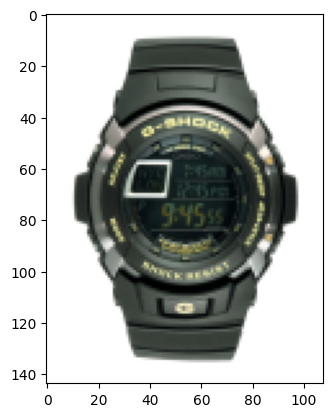

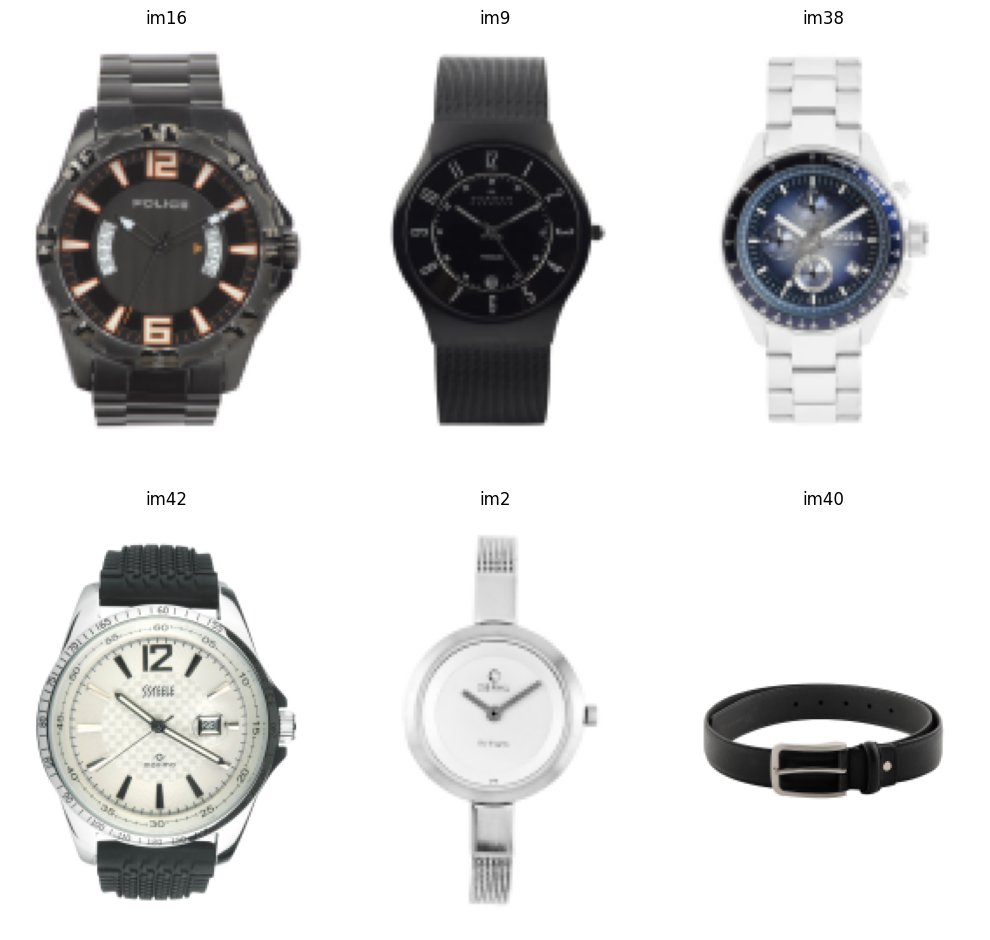

In [49]:
idx_ref = 20

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# 5. Tìm kiếm với ảnh tương đồng với một ảnh đầu vào

In [50]:
dataset_path = "/kaggle/input/image-test/"
files = os.listdir(dataset_path)

print(files[:5]) 

['dry-men-s-running-breathable-t-shirt-blue-decathlon-8666011.jpg', 'images.jpg']


In [51]:
# hàm embedding image đầu vào
def image_embedding(model, img_path):
    # Reshape
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [52]:
img_path_test = "/kaggle/input/image-test/images.jpg"
emb = image_embedding(model, img_path_test)
print(emb)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.        0.8300841 1.2210524 ... 1.3982286 1.0050421 5.5376697]


In [53]:
# hàm lấy các index recomment theo cosine score với emb ảnh đầu vào
def get_recommender_2(emb, df, k = 5):
    # Tính khoảng cách cosine giữa x và tất cả các vector trong df
    distances = pairwise_distances([emb], df.values, metric='cosine')[0]

    # Lấy index của k vector có khoảng cách nhỏ nhất
    top_k_idx = np.argsort(distances)[:k]
    
    return top_k_idx, df.iloc[top_k_idx].assign(distance=distances[top_k_idx])

# recomment score top 5
index_list, _ = get_recommender_2(emb, df_embs, k = 6)

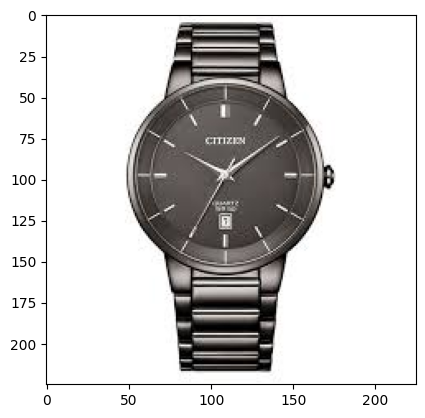

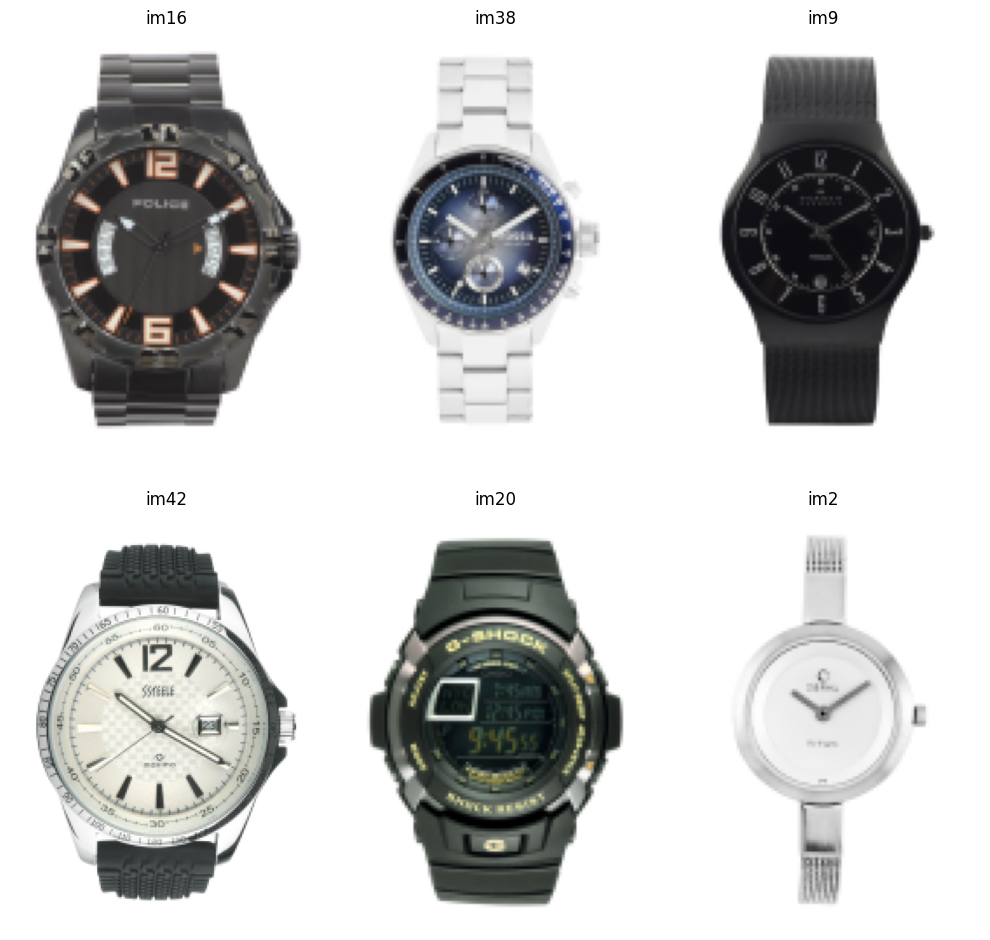

In [54]:
# Plot
#===================
plt.imshow(image.load_img(img_path_test))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[index_list].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# 6. Load dữ liệu từ FAISS

In [55]:
faiss_data = "faiss_fashion.pkl"
index_file = "faiss_fashion_index.index"
if os.path.exists(index_file) and os.path.exists(faiss_data):
    index_loaded = faiss.read_index(index_file)
    with open(faiss_data, 'rb') as f:
        df_loaded = pickle.load(f)

In [56]:
emb.shape

(2048,)

In [57]:
emb = emb.reshape(1, emb.shape[0])

In [58]:
# recomment score top 5
distances, indices = index_loaded.search(emb, 6)

In [59]:
indices

array([[16, 42, 20, 38,  9,  2]])

In [60]:
index_loaded.ntotal

50

In [61]:
indices[0]

array([16, 42, 20, 38,  9,  2])

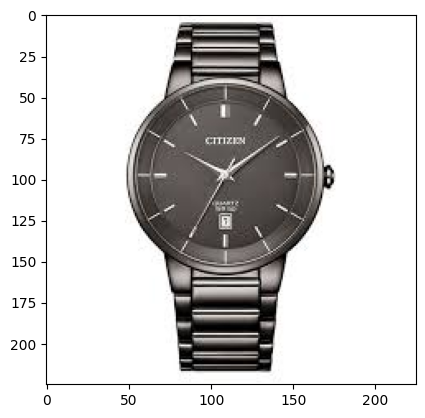

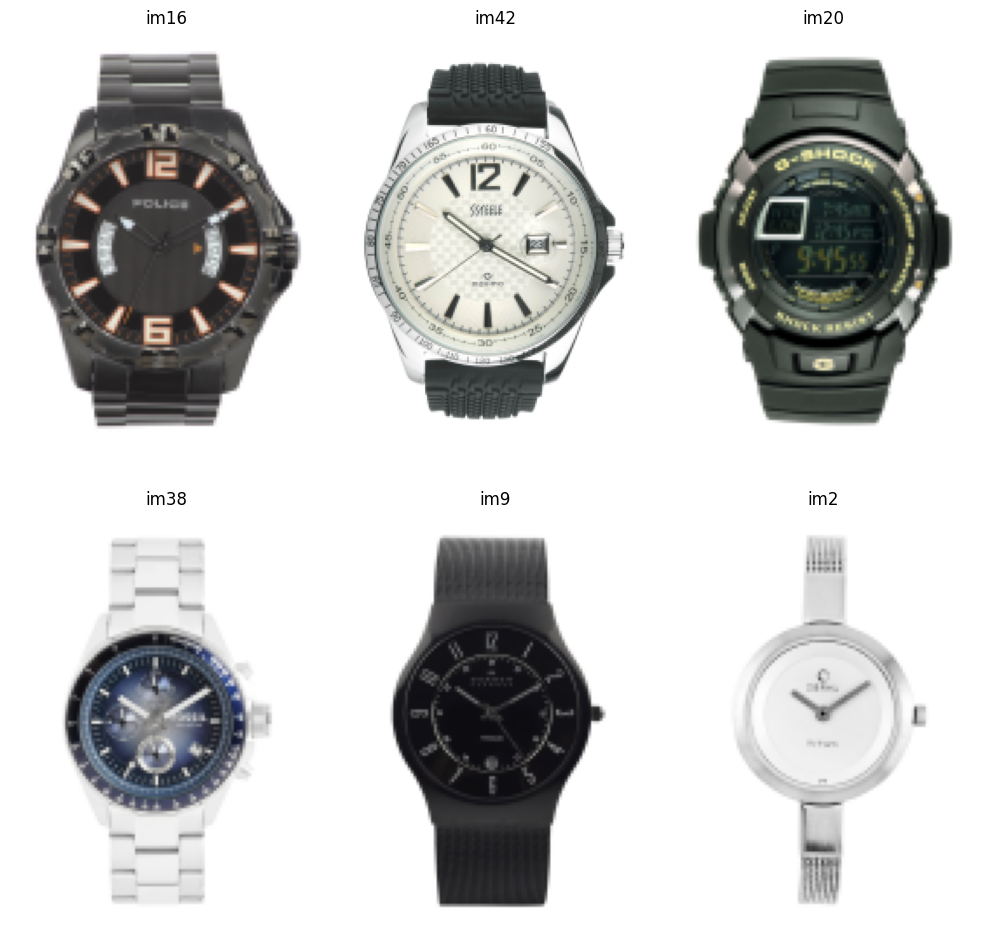

In [62]:
# Plot
#===================
plt.imshow(image.load_img(img_path_test))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[indices[0]].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [64]:
model.save("fashion_resnet50.h5")